In [2]:
import player_data_setup as setup
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:

player_name = "lebron_james"
player_team = "LAL"
opponent = "OKC"
change = "" # if you made a big model change, what was it?
player_df = setup.player_data_merge(f"./data/player_game_data/{player_team}/{player_name}.csv")
team_stats_df = pd.read_csv("./data/team_def_stats.csv")


In [4]:
player_df

,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,...,TOV,PF,PTS,Home,DRtg,Pace,eFG%_y,TOV%,DRB%,FT/FGA
0,34.650000,7,16.0,.438,1,4,.250,6,12,.500,...,2,3,16.0,1,111.7,97.3,0.531,13.2,74.5,0.180
1,34.700000,7,21.0,.538,2,5,.400,5,8,.625,...,2,1,21.0,1,118.4,97.5,0.544,10.8,73.9,0.192
2,33.766667,12,32.0,.545,4,9,.444,8,13,.615,...,5,3,32.0,1,115.0,98.8,0.550,12.6,77.2,0.202
3,33.766667,12,32.0,.545,4,9,.444,8,13,.615,...,5,3,32.0,1,115.0,98.8,0.550,12.6,77.2,0.202
4,35.800000,3,11.0,.214,2,5,.400,1,9,.111,...,2,1,11.0,0,118.4,97.5,0.544,10.8,73.9,0.192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,37.450000,10,25.0,.476,2,5,.400,8,16,.500,...,3,3,25.0,0,112.4,103.7,0.531,13.0,74.3,0.201
66,37.666667,5,16.0,.417,2,4,.500,3,8,.375,...,3,1,16.0,1,110.0,98.6,0.521,12.9,75.4,0.190
67,39.850000,10,33.0,.667,5,8,.625,5,7,.714,...,4,2,33.0,1,112.0,99.2,0.538,13.6,75.7,0.194
68,32.650000,9,27.0,.529,2,7,.286,7,10,.700,...,1,1,27.0,1,119.3,99.3,0.563,12.7,71.8,0.178


In [5]:
player_df = setup.get_rolling_avgs(player_df)

In [6]:
player_df

,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,...,MP_last_5_avg,Opp_DRtg_x_PTS,Opp_Pace_x_FGA,Opp_eFG_x_PTS,PTS_rolling_trend,PTS_5_game_trend,PTS_volatility_5,Hot_Streak,PTS_per_minute,PTS_pct_of_max
0,34.650000,7,16.0,.438,1,4,.250,6,12,.500,...,34.650000,1787.20,1556.80,8.4960,0.00,0.00,0.000000,0.0,0.461760,1.000000
1,34.700000,7,21.0,.538,2,5,.400,5,8,.625,...,34.675000,2190.40,1803.75,10.0640,0.00,0.00,0.000000,0.0,0.605187,0.880952
2,33.766667,12,32.0,.545,4,9,.444,8,13,.615,...,34.372222,2645.00,2272.40,12.6500,0.00,0.00,3.535534,1.0,0.947680,0.718750
3,33.766667,12,32.0,.545,4,9,.444,8,13,.615,...,34.220833,2903.75,2494.70,13.8875,0.00,2.25,8.185353,2.0,0.947680,0.789062
4,35.800000,3,11.0,.214,2,5,.400,1,9,.111,...,34.536667,2652.16,2184.00,12.1856,0.00,-2.85,8.057088,3.0,0.307263,0.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,37.450000,10,25.0,.476,2,5,.400,8,16,.500,...,36.746667,2562.72,2364.36,12.1068,-1.70,0.60,7.574812,0.0,0.667557,0.542857
66,37.666667,5,16.0,.417,2,4,.500,3,8,.375,...,36.785000,2376.00,2129.76,11.2536,-1.54,-0.20,6.860515,1.0,0.424779,0.514286
67,39.850000,10,33.0,.667,5,8,.625,5,7,.714,...,37.216667,2598.40,2301.44,12.4816,-0.08,1.80,6.899275,1.0,0.828105,0.552381
68,32.650000,9,27.0,.529,2,7,.286,7,10,.700,...,37.156667,2684.25,2234.25,12.6675,1.16,2.80,7.539525,2.0,0.826953,0.535714


In [7]:
print(player_df.columns) # for reference!

Index(['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%_x', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Home', 'DRtg', 'Pace', 'eFG%_y', 'TOV%', 'DRB%',
       'FT/FGA', 'PTS_last_5_avg', 'FGA_last_5_avg', 'MP_last_5_avg',
       'Opp_DRtg_x_PTS', 'Opp_Pace_x_FGA', 'Opp_eFG_x_PTS',
       'PTS_rolling_trend', 'PTS_5_game_trend', 'PTS_volatility_5',
       'Hot_Streak', 'PTS_per_minute', 'PTS_pct_of_max'],
      dtype='object')


In [8]:
scaler = StandardScaler()
columns_to_scale = [  "Pace", "TOV%", "DRB%",
    'PTS_last_5_avg',  'MP_last_5_avg',
          'PTS_5_game_trend',
        'PTS_volatility_5',
        'Hot_Streak',
        'PTS_rolling_trend',
        'PTS_per_minute',
        'PTS_pct_of_max',
]


exiled = ['MP_x_FGA', 'FGA_last_5_avg', 'Opp_DRtg_x_PTS',
       'Opp_Pace_x_FGA', 'Opp_eFG_x_PTS','DRtg', 'FT/FGA',] # stats that were unhelpful or overfitting
player_df[columns_to_scale] = scaler.fit_transform(player_df[columns_to_scale])

Random Forest Regression Model

In [9]:
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)


XGBoost Model

In [10]:

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,           
    learning_rate=0.05,           
    max_depth=8,                
    subsample=0.8,                
    colsample_bytree=0.8,          
    seed=42                       
)

Stacked Model

In [11]:
estimators = [
    ('rf', rfr_model),
    ('xgb', xgb_model)
]
stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),  # Better than plain LinearRegression
    cv=5  # Ensure proper cross-validation
)

Here's our splits

In [12]:
X, X_test, X_train, y_train, y_test = setup.get_splits(player_df)

And finally we fit the models.

In [13]:
rfr_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
stacked_model.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=RidgeCV())

In [14]:

rfr_y_pred = rfr_model.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)
stacked_y_pred = stacked_model.predict(X_test)

rfr_mae = mean_absolute_error(y_test, rfr_y_pred)
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
stacked_mae = mean_absolute_error(y_test, stacked_y_pred)

rfr_rmse = np.sqrt(mean_squared_error(y_test, rfr_y_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
stacked_rmse = mean_squared_error(y_test, stacked_y_pred)

print(f"Mean Absolute Error (MAE): Random Forest : {rfr_mae:.2f}")
print(f"Mean Absolute Error (MAE): XGBoost : {xgb_mae:.2f}")
print(f"Mean Absolute Error (MAE): Stacked : {stacked_mae:.2f}")
print()
print(f"Root Mean Squared Error (RMSE):  Random Forest : {rfr_rmse:.2f}")
print(f"Root Mean Squared Error (RMSE): XGBoost : {xgb_rmse:.2f}")
print(f"Root Mean Squared Error  (RMSE): Stacked : {stacked_rmse:.2f}")


Mean Absolute Error (MAE): Random Forest : 3.42
Mean Absolute Error (MAE): XGBoost : 2.86
Mean Absolute Error (MAE): Stacked : 3.30

Root Mean Squared Error (RMSE):  Random Forest : 4.54
Root Mean Squared Error (RMSE): XGBoost : 3.70
Root Mean Squared Error  (RMSE): Stacked : 18.79


Here's a plot of feature importance from XGBoost. Helpful, but I've also noticed it varies by player.

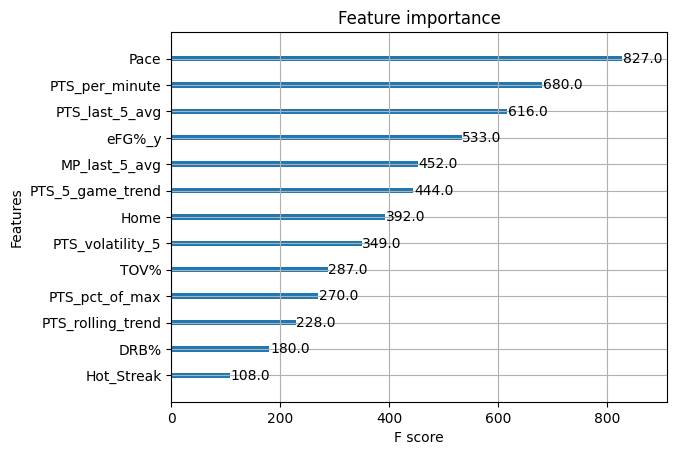

In [15]:
xgb.plot_importance(xgb_model, importance_type="weight")
plt.show()

NOW:

It's time to predict a specific game. You entered the opponent and all necessary information at the top. So, just let it run!

In [16]:
# put in opponent, player_df, and team_stats_df to prep the game stats. this makes for minimal need for manual data adjustment
input_game = setup.prep_game(opponent, player_df, team_stats_df)

In [17]:
input_game # for viewing. I recommend installing the Data Wrangler extension- it allows for easier viewing of dfs when typed like this

,Home,Pace,eFG%_y,TOV%,DRB%,PTS_last_5_avg,MP_last_5_avg,PTS_5_game_trend,PTS_volatility_5,Hot_Streak,PTS_per_minute,PTS_pct_of_max,PTS_rolling_trend
0,0,99.9,0.514,15.0,74.7,21.3,36.193333,1.08,NaN,2.0,0.554745,0.507143,1.08


Here's the predicted points scored based on each model, with the MAE of each model as a reminder.

In [18]:
predicted_pts_rfg = setup.predict_game(input_game, scaler,columns_to_scale, rfr_model,X)
predicted_pts_xgb= setup.predict_game(input_game, scaler,columns_to_scale, xgb_model,X)
predicted_pts_stacked = setup.predict_game(input_game, scaler, columns_to_scale, stacked_model,X)
print(f"Predicted Points Random Forest: {predicted_pts_rfg:>6.1f}")
print(f"Predicted Points XGBoost: {predicted_pts_xgb:>12.1f}")
print(f"Predicted Points Stacked: {predicted_pts_stacked:>12.1f}")
print(f"MAE Random Forest : {rfr_mae:>10.2f}")
print(f"MAE XGBoost: {xgb_mae:>17.2f}")
print(f"MAE Stacked: {stacked_mae:>17.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Predicted Points Random Forest:   28.9
Predicted Points XGBoost:         26.9
Predicted Points Stacked:         28.4
MAE Random Forest :       3.42
MAE XGBoost:              2.86
MAE Stacked:              3.30


In [19]:
prediction_data = {
    
    "player" : [player_name],
    "opponent": [opponent],
    "xgb" : [f"xbg: {predicted_pts_xgb:.2f}"],
    "rfr" : [f"rfg: {predicted_pts_rfg}"],
    "stacked" : [f"stacked: {predicted_pts_stacked:.2f}"],
    "change_made": [change]
    
}
error_data = {
    "player": [player_name],
    "mae": [[f"XGB: {xgb_mae:.2f}", f"RFR: {rfr_mae:.2f}", f"Stacked: {stacked_mae:.2f}"]],  
    "rmse": [[f"XGB: {xgb_rmse:.2f}", f"RFR: {rfr_rmse:.2f}", f"Stacked: {stacked_rmse:.2f}"]],  
    "change_made": [change]
}
pred_df = pd.DataFrame(prediction_data)
error_df = pd.DataFrame(error_data)
# this next line writes a line to the csv file for documentation purposes.
# i have it commented out for now.
# pred_df.to_csv('./data/predictions.csv', mode='a', header=False, index=False)
# error_df.to_csv('./data/model_error.csv', mode='a', header=False, index=False)

In [20]:
print(player_df)

           MP  FG   FGA   FG% 3P 3PA    3P% 2P 2PA   2P%  ... MP_last_5_avg  \
0   34.650000   7  16.0  .438  1   4   .250  6  12  .500  ...     -0.271534   
1   34.700000   7  21.0  .538  2   5   .400  5   8  .625  ...     -0.245840   
2   33.766667  12  32.0  .545  4   9   .444  8  13  .615  ...     -0.557019   
3   33.766667  12  32.0  .545  4   9   .444  8  13  .615  ...     -0.712608   
4   35.800000   3  11.0  .214  2   5   .400  1   9  .111  ...     -0.388012   
..        ...  ..   ...   ... ..  ..    ... ..  ..   ...  ...           ...   
65  37.450000  10  25.0  .476  2   5   .400  8  16  .500  ...      1.883306   
66  37.666667   5  16.0  .417  2   4   .500  3   8  .375  ...      1.922703   
67  39.850000  10  33.0  .667  5   8   .625  5   7  .714  ...      2.366346   
68  32.650000   9  27.0  .529  2   7   .286  7  10  .700  ...      2.304682   
69  34.250000   9  19.0  .563  1   1  1.000  8  15  .533  ...      1.314620   

   Opp_DRtg_x_PTS Opp_Pace_x_FGA Opp_eFG_x_PTS PTS_

In [21]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    # Ensure test data is always AFTER training data
    print(f"Train: {train_index}, Test: {test_index}")

Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], Test: [15 16 17 18 19 20 21 22 23 24 25]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25], Test: [26 27 28 29 30 31 32 33 34 35 36]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36], Test: [37 38 39 40 41 42 43 44 45 46 47]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47], Test: [48 49 50 51 52 53 54 55 56 57 58]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58], Test: [59 60 61 62 63 64 65 66 67 68 69]


In [25]:
# Your feature list
to_test = ['Home', 'Pace', 'eFG%_y', 'TOV%', 'DRB%', 
       'PTS_last_5_avg',  'MP_last_5_avg',   'PTS_5_game_trend', 'PTS_volatility_5', 
       'Hot_Streak',  "PTS_per_minute", "PTS_pct_of_max", "PTS_rolling_trend"]

# Calculate correlations with PTS (target)
correlations = player_df[to_test + ['PTS']].corr()[['PTS']].sort_values('PTS', ascending=False)

# Display clean results
print(correlations.drop('PTS'))  # Remove self-correlation

                        PTS
PTS_per_minute     0.945882
PTS_5_game_trend   0.690025
PTS_last_5_avg     0.355764
PTS_rolling_trend  0.298500
TOV%               0.283818
eFG%_y             0.263548
PTS_pct_of_max     0.122407
Hot_Streak         0.111713
Home               0.107976
Pace               0.080076
DRB%               0.078108
PTS_volatility_5  -0.012373
MP_last_5_avg     -0.182437


In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data.sort_values("VIF", ascending=False))

              feature       VIF
10     PTS_per_minute  2.825262
9          Hot_Streak  2.663301
7    PTS_5_game_trend  2.476956
0                Home  2.464906
12  PTS_rolling_trend  2.356946
5      PTS_last_5_avg  2.250430
2              eFG%_y  2.198972
8    PTS_volatility_5  1.633490
11     PTS_pct_of_max  1.586759
6       MP_last_5_avg  1.543194
3                TOV%  1.344909
1                Pace  1.239935
4                DRB%  1.099971
